In [1]:
!pip install edlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.6/305.6 KB 1.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import pandas as pd
import os
import unicodedata
from tqdm import tqdm
import edlib

In [3]:
PATH_TO_DATA_FOLDER = "../input/corpus-of-russian-news-articles-from-lenta"
data = pd.read_csv(os.path.join(PATH_TO_DATA_FOLDER,'lenta-ru-news.csv'))

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
titles = data['title'].where(data.date.apply(lambda x: x.split('/')[0] in ['2018','2019'])).dropna(how = 'all')
titles = titles.where(titles.apply(lambda x: len(x.split(' ')) >= 5)).dropna()
titles = titles.sample(12500, random_state = 1).apply(lambda x: unicodedata.normalize("NFKD", x)).values

<AxesSubplot:>

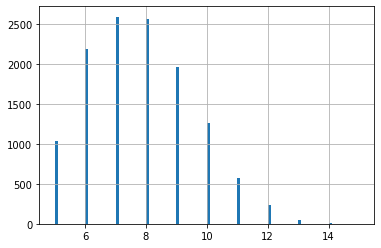

In [5]:
pd.DataFrame(titles)[0].apply(lambda x: len(x.split())).hist(bins = 100)

In [6]:
PATH_TO_TASK_FOLDER = "../input/fake-news-task"
train = pd.read_csv(os.path.join(PATH_TO_TASK_FOLDER,'train.tsv'), sep = '\t')
test = pd.read_csv(os.path.join(PATH_TO_TASK_FOLDER,'test.tsv'), sep = '\t')

data = train.append(test, ignore_index = True)['title'].values
data

array(['Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы',
       'Агент Кокорина назвал езду по встречке житейской историей',
       'Госдума рассмотрит возможность введения секретных статей Уголовного кодекса',
       ...,
       'СК возбудил дело против авиакомпании «Победа» за финансирование Навального',
       'Криптомонетный двор Туркменистана выпустил юбилейные биткоины',
       'Deutsche Bahn заплатит рекордный штраф за чтение писем сотрудников'],
      dtype=object)

In [7]:
DISTANCE_THRESHOLD = 10

def calculate_distance(word1, word2, distance_threshold = DISTANCE_THRESHOLD):
    return edlib.align(word1, word2, k = distance_threshold)['editDistance']

def get_unique_parsed_text(parsed_data, task_data, distance_threshold = DISTANCE_THRESHOLD):
    result = list()
    task_data = [x.lower().strip() for x in task_data]
    for i, parsed_text in tqdm(enumerate(map(lambda x: x.lower().strip(), parsed_data)), total = len(parsed_data)):
        seen = False
        for task_text in task_data:
            if 0 <= calculate_distance(parsed_text, task_text, distance_threshold) < distance_threshold:
                seen = True
                break
        if not seen:
            result.append(parsed_data[i])
    return result

parsed_long = get_unique_parsed_text(titles, data)

100%|██████████| 12500/12500 [1:19:00<00:00,  2.64it/s]


In [8]:
np.save('lenta_titles', parsed_long)

In [9]:
len(parsed_long)

12480